In [1]:
from astropy.io import fits
import pyregion
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as cte 
import regions
from astropy.wcs import WCS
import cmasher as cm
import seaborn as sn
from discrete_gaussian_model import DiscreteGaussianModel
from astropy.nddata import Cutout2D
from astropy.coordinates import Angle
from astropy.modeling import models, fitting
from astropy.modeling.models import Const1D
from astropy.table import QTable, Table
from astropy.coordinates import SkyCoord
FITTER = fitting.LevMarLSQFitter()

/home/roberto/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
D = 5429*u.pc                      # conversation with Jane
v_inf = 710*u.km*(1/u.second)      # Hanmman
M_loss = (2.0E-5)*u.M_sun*(1/u.yr) #Crowther 1999
L = 10**(49.1)*(1/u.second)        # Hanmman

In [3]:
from astropy.table import QTable, Table
datos_HST = QTable.read('m1-67-globule-parameters.ecsv')
datos_JWST = QTable.read('m1-67-globule-parameters-JWST.ecsv')
datos_HST

PA,Sep,Bcore,Bshell,Bbg,Rcore,Rshell,Hshell,Group,Lat
deg,arcsec,,,,arcsec,arcsec,arcsec,,deg
float64,float64,float64,float64,float64,float64,float64,float64,object,float64
296.28,2.98,0.32,0.25,0.49,0.05,nan,0.14,None,71.28
66.85,3.16,nan,nan,0.73,nan,1.10,nan,NE-04,21.85
30.92,3.31,1.17,0.41,0.91,0.14,0.45,0.16,NE-04,14.08
71.97,3.52,0.54,nan,0.54,0.10,nan,nan,NE-04,26.97
16.83,3.80,0.64,nan,0.82,0.09,nan,nan,NE-04,28.17
57.69,4.38,0.14,nan,0.45,0.06,1.45,nan,NE-04,12.69
337.94,4.52,0.53,0.17,0.24,0.11,0.60,0.25,NE-04,67.06
49.98,4.95,0.42,0.11,0.44,0.13,0.71,0.60,NE-04,4.98


In [4]:
datos_JWST

PA,Sep,Bcore,Bshell,Bbg,Rcore,Rshell,Hshell
deg,arcsec,,,,arcsec,arcsec,arcsec
float64,float64,float64,float64,float64,float64,float64,float64
296.28,2.98,2.50,2.96,2.67,0.07,0.41,0.27
66.87,3.15,1.82,2.07,3.14,0.08,0.62,0.24
30.92,3.31,1.74,0.78,6.37,0.07,0.34,0.16
71.97,3.52,1.39,1.17,2.86,0.09,0.98,0.41
16.83,3.80,2.28,0.01,3.65,0.08,1.50,0.01
57.69,4.38,0.01,0.01,2.35,0.01,1.50,0.01
337.92,4.52,6.91,0.80,3.41,0.11,0.10,1.00
49.98,4.95,1.51,0.01,2.90,0.03,0.54,0.01


(array([51., 57., 31., 16.,  4.,  3.,  4.,  1.,  0.,  1.]),
 <Quantity [0.01      , 0.04799178, 0.08598356, 0.12397534, 0.16196712,
            0.1999589 , 0.23795068, 0.27594246, 0.31393424, 0.35192602,
            0.3899178 ] arcsec>,
 <BarContainer object of 10 artists>)

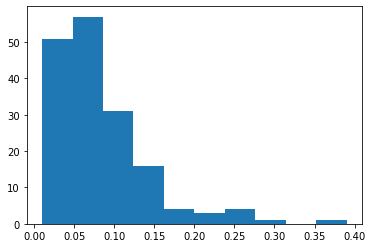

In [5]:
plt.hist(datos_JWST['Rcore'])

(array([80., 13., 19., 19., 11.,  2.,  6.,  1.,  1., 16.]),
 <Quantity [0.1 , 0.24, 0.38, 0.52, 0.66, 0.8 , 0.94, 1.08, 1.22, 1.36,
            1.5 ] arcsec>,
 <BarContainer object of 10 artists>)

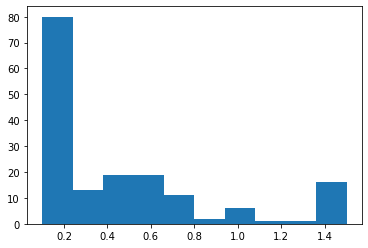

In [6]:
plt.hist(datos_JWST['Rshell'])

In [7]:
che = np.loadtxt('color.txt')
che

FileNotFoundError: color.txt not found.

In [ ]:
len(che)

In [ ]:
num = np.loadtxt('checar.txt')
num

In [ ]:
len(num)

In [8]:
R_c_HST = []
R_s_HST = []
H_s_HST = []
R_c_JWST = []
R_s_JWST = []
H_s_JWST = []
for i in range(len(datos_HST)):
    if i not in num:
        R_c_HST.append(datos_HST['Rcore'][i])
        R_s_HST.append(datos_HST['Rshell'][i])
        H_s_HST.append(datos_HST['Hshell'][i])
        R_c_JWST.append(datos_JWST['Rcore'][i])
        R_s_JWST.append(datos_JWST['Rshell'][i])
        H_s_JWST.append(datos_JWST['Hshell'][i])

NameError: name 'num' is not defined

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

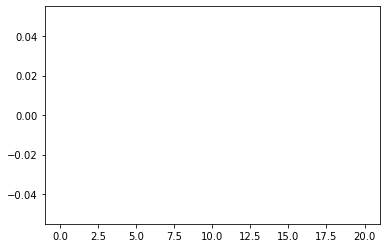

In [9]:
r_1_r_0_HST = []
for i in range(len(R_c_HST)):
    r_1_r_0_HST.append(R_s_HST[i]/R_c_HST[i])
plt.hist(r_1_r_0_HST,bins=20,range=(0,20))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

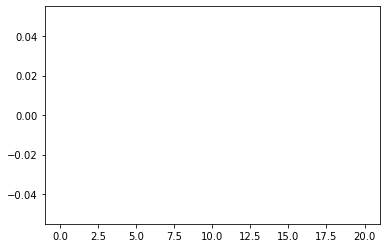

In [10]:
r_1_r_0_JWST = []
for i in range(len(R_c_JWST)):
    r_1_r_0_JWST.append(R_s_JWST[i]/R_c_JWST[i])
plt.hist(r_1_r_0_JWST,bins=20,range=(0,20))

In [ ]:
.01*np.sqrt(2)

# Ahora vamos a sacar los valores que predice el modelo y comparar con los obtenidos por las observaciones
 ## radios

/home/roberto/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


IndexError: index 168 is out of bounds for axis 0 with size 168

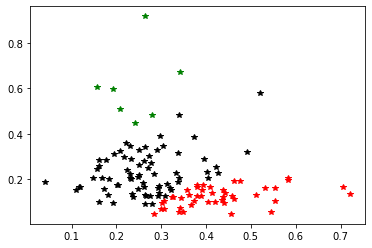

In [11]:
r_FWHM_HST = 2*(np.sqrt(2*(np.log(2))))*datos_HST['Rcore']
r_FWHM_JWST = 2*(np.sqrt(2*(np.log(2))))*datos_JWST['Rcore']

from astropy import units as u
from astropy import constants as cte
w_HST = 0.067*u.arcsec
r_HST = (r_FWHM_HST**2-w_HST**2)**(1/2)
w_JWST = 0.033*u.arcsec
r_JWST = (r_FWHM_JWST**2-w_JWST**2)**(1/2)

r = np.linspace(0,1)*u.arcsec
r_HST_model = np.hypot(r,w_HST)
r_JWST_model = np.hypot(r,w_JWST)
#plt.plot(r_HST,r_JWST,'*',color='b')
colors_globules = []
for i in range(len(r_HST)):
    if 0.2*u.arcsec <= (r_HST[i]-r_JWST[i]):
        plt.plot(r_HST[i],r_JWST[i],'*',color='r')
        colors_globules.append('r')
    elif -0.2*u.arcsec >= (r_HST[i]-r_JWST[i]):
        plt.plot(r_HST[i],r_JWST[i],'*',color='g')
        colors_globules.append('g')
    else:
        plt.plot(r_HST[i],r_JWST[i],'*',color='k')
        colors_globules.append('k')
plt.plot(r_HST_model,r_JWST_model,color='r')
plt.xlabel(r'$r_{HST}$')
plt.ylabel(r'$r_{JWST}$')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal')
plt.show()

In [12]:
datos_HST['Color'] = colors_globules
datos_JWST['Color'] = colors_globules

ValueError: Inconsistent data column lengths

In [ ]:
r_1_0_HST = datos_HST['Rshell']/datos_HST['Rcore']
r_1_0_JWST = datos_JWST['Rshell']/datos_JWST['Rcore']

In [ ]:
plt.hist(r_1_0_HST,bins=20)

In [ ]:
plt.hist(r_1_0_JWST,bins=20)

In [ ]:
datos_HST['X'] = r_1_0_HST
datos_JWST['X'] = r_1_0_JWST

 ## densidades

In [ ]:
E = (6.61E-27*2.99E10)/(6.563E-5)*(u.erg)
l_HST = 2*np.sqrt(2*datos_HST['Rshell'].value*D.value*datos_HST['Hshell'].value*D.value)*u.AU
EM_HST = (datos_HST['Bshell'])*(0.0137*4*np.pi)/(3.61E5*E.value)*u.pc/(u.cm**6)
n_shell_HST = (EM_HST/(l_HST.to('pc')))**(1/2)

In [ ]:
datos_HST['n_shell'] = n_shell_HST
datos_HST

In [ ]:
plt.hist(datos_HST['n_shell'])

In [ ]:
T = 6000*u.K
m = (0.6*u.M_p).to('g')
c_s = np.sqrt((cte.k_B).to('erg/K')*T/m)
c_s.to('km/s')

In [ ]:
v_A_1 = 1*u.km/u.second
n10_1 = (v_A_1/c_s.to('km/s'))**2
v_A_2 = 2*u.km/u.second
n10_2 = (v_A_2/c_s.to('km/s'))**2
v_A_3 = 3*u.km/u.second
n10_3 = (v_A_3/c_s.to('km/s'))**2
print(n10_1,n10_2,n10_3)

## Presiones

In [ ]:
P = (M_loss*v_inf)/(4*np.pi*((datos_HST['Sep'].value*D.value*u.AU).to('cm'))**2)
plt.hist(P)

In [ ]:
P_g = 2*datos_HST['n_shell']*m*c_s**2
plt.hist(P_g)

In [ ]:
plt.hist((P.cgs)/(P_g.cgs),bins=30)

In [ ]:
datos_HST['X_P'] = (P.cgs)/(P_g.cgs)
datos_HST

In [ ]:
plt.plot(datos_HST['X'],datos_HST['X_P'],'*')
plt.xlim(1,10)
plt.ylim(0.001,15)
plt.xscale('log')
plt.yscale('log')



In [ ]:
type(datos_HST['Color'][0])

In [ ]:
from scipy.optimize import fsolve

def find_root(x):
    """Should be called with vector argument of same length as P_P_0"""
    return ((1+x**2)/2)*(np.e**((1-x**2)/2)) - P_P0 #equation to find the root

#M0 = fsolve(func_to_find_M0, 1.5 * np.ones_like(P_P_0)) 

P_P0 = np.arange(0.01,1.01,0.01)
M0 = fsolve(find_root,1.5 * np.ones_like(P_P0))
alpha=2      #spherical case
rho1 = np.exp((1-M0**2)/2)
r1 = (M0**(-1/alpha))*np.exp((M0**2-1)/(2*alpha))
rho2 = (M0**2)*rho1
h2 = (3/(4*M0**2)) * r1
#EM2a = (rho2)**2 * h2 / h_0
#EM2=(rho2)**2*(r1*h2/h_0)**(1/2)
plt.plot(r1,P_P0,label=r'$P/P_0$')
#plt.plot(r1,EM2a,label=r'$E_2/E_0$ perpendicular emission measure ')
#plt.plot(r1,EM2,label=r'$S_2/S_0$ tangential emission measure ')
#plt.plot(r1,M0,label=r'$M_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
#plt.plot(r1,rho2,label=r'$\rho_2/\rho_0$')
#plt.plot(r1,h2,label=r'$h_2/r_0$')

plt.plot(datos_HST['X'],1/datos_HST['X_P'],'*')
plt.plot(np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])]),n10_1,'*',color='b')
plt.plot(np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])]),n10_2,'*',color='k')
plt.plot(np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])]),n10_3,'*',color='r')
plt.xlim(1,10)
plt.ylim(0.001,15)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])])

In [ ]:
dist = np.arange(3,35,0.1)*u.arcsec
P_RAM = M_loss*v_inf/(4*np.pi*(((dist.value*D.value*u.AU)).to('cm'))**2)
plt.plot(dist,P_RAM.cgs)
plt.plot(datos_HST['Sep'],P_g.cgs,'*')
plt.yscale('log')

In [ ]:
cos_i = (1/datos_HST['X_P'])**(2/5)
datos_HST['cos_i']=cos_i
plt.hist(cos_i)

In [ ]:
datos_HST

In [ ]:
plt.plot(r1,P_P0,label=r'$P/P_0$')
#plt.plot(r1,EM2a,label=r'$E_2/E_0$ perpendicular emission measure ')
#plt.plot(r1,EM2,label=r'$S_2/S_0$ tangential emission measure ')
#plt.plot(r1,M0,label=r'$M_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
#plt.plot(r1,rho2,label=r'$\rho_2/\rho_0$')
#plt.plot(r1,h2,label=r'$h_2/r_0$')

plt.plot(datos_HST['X'],1/datos_HST['X_P']*(cos_i**(5/2)),'*')
plt.plot(datos_HST['X'],1/datos_HST['X_P'],'*',color='r')
plt.plot(np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])]),n10_1,'+',color='b')
plt.plot(np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])]),n10_2,'+',color='k')
plt.plot(np.mean(datos_HST['X'][np.isfinite(datos_HST['X'])]),n10_3,'+',color='r')
plt.xlim(1,10)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')


plt.plot(datos_JWST['X'],1/datos_HST['X_P']*(cos_i**(5/2)),'*')
plt.plot(datos_JWST['X'],1/datos_HST['X_P'],'*',color='r')
plt.plot(np.mean(datos_JWST['X'][np.isfinite(datos_JWST['X'])]),n10_1,'+',color='b')
plt.plot(np.mean(datos_JWST['X'][np.isfinite(datos_JWST['X'])]),n10_2,'+',color='k')
plt.plot(np.mean(datos_JWST['X'][np.isfinite(datos_JWST['X'])]),n10_3,'+',color='r')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    plt.plot(datos_HST['X'][i],1/datos_HST['X_P'][i],'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    plt.plot(datos_HST['X'][i],1/datos_HST['X_P'][i]*cos_i[i]**(5/2),'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    plt.plot(datos_JWST['X'][i],1/datos_HST['X_P'][i],'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    plt.plot(datos_JWST['X'][i],1/datos_HST['X_P'][i]*cos_i[i]**(5/2),'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
curiosos = np.loadtxt('checar.txt')
curiosos

In [ ]:
for i in range(len(datos_HST)):
    if i in curiosos:
        plt.plot(datos_JWST['X'][i],1/datos_HST['X_P'][i]*cos_i[i]**(5/2),'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
good = np.loadtxt('Seleccionados_ind.txt')
good

In [ ]:
for i in range(len(datos_HST)):
    if i in good:
        plt.plot(datos_JWST['X'][i],1/datos_HST['X_P'][i]*cos_i[i]**(5/2),'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    if i in good:
        plt.plot(datos_JWST['X'][i],1/datos_HST['X_P'][i],'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    if i in good:
        plt.plot(datos_HST['X'][i],1/datos_HST['X_P'][i],'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [ ]:
for i in range(len(datos_HST)):
    if i in good:
        plt.plot(datos_HST['X'][i],1/datos_HST['X_P'][i]*cos_i[i]**(5/2),'*',color=datos_HST['Color'][i])

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')
plt.xlim(1,15)
plt.ylim(0.001,11)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()